In [1]:
from loadingCGAN.novgan_trafic_input import Novgan_trafic_input
from load_data.load_data import load_data
from utils.config_novgan_trafic_input import *
from loadingCGAN.utils_cgan import creating_dico_index
from time import time
import numpy as np
from loadingCGAN.utils_cgan import save_time

Using TensorFlow backend.


In [2]:
########
# DATA #
########
x_train, _, y_train, _, x_balanced_train, _, x_test, y_test, colnames = load_data(place=place,
                                                                                  attack_mode=attack_mode,
                                                                                  attack=attack,
                                                                                  nrows=nrows,
                                                                                  cv_size=cv_size,
                                                                                  log_transform=False,
                                                                                  shuffle=shuffle,
                                                                                  return_colnames=True)
x_train_bad = np.array([x for x, y in zip(x_train, y_train) if int(y) == 1])
x_train = np.array([x for x, y in zip(x_train, y_train) if int(y) == 0])

x_test_bad = np.array([x for x, y in zip(x_test, y_test) if int(y) == 1])
x_test = np.array([x for x, y in zip(x_test, y_test) if int(y) == 0])


if balanced_train_size is not None:
    x_balanced_train = x_balanced_train[:balanced_train_size]

data_dim = x_train.shape[1]
dico_index = creating_dico_index(colnames=colnames)

/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train data shape is (86174, 115)
Test data shape is (86174, 115)

  
 
 
  
 
 
Train data shape is (65458, 115)

  
 
 
  
 
 
x_train overview
        0         1         2    3    4         5    6    7    8    9    ...  \
0 -1.000000 -0.999975 -0.999891 -1.0 -1.0 -1.000000 -1.0 -1.0 -1.0 -1.0  ...   
1 -0.998667 -0.999880 -0.998383 -1.0 -1.0 -0.220779 -1.0 -1.0 -1.0 -1.0  ...   
2 -1.000000 -0.999990 -1.000000 -1.0 -1.0 -1.000000 -1.0 -1.0 -1.0 -1.0  ...   
3 -1.000000 -0.999974 -0.999849 -1.0 -1.0 -1.000000 -1.0 -1.0 -1.0 -1.0  ...   
4 -1.000000 -0.999872 -0.999849 -1.0 -1.0 -1.000000 -1.0 -1.0 -1.0 -1.0  ...   

   105  106  107  108  109  110  111  112  113  114  
0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
1 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
2 -1.0 -1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0 -1.0 -1.0  
3 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
4 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  

[5 rows x 115 columns]

  
 
 
  
 
 
y_train ove

In [3]:
##########
# NovGan #
##########
novgan_trafic_input = Novgan_trafic_input(data_dim=data_dim, activation=activation, verbose=True,
                                          noise_dim=noise_dim,
                                          leaky_relu=leaky_relu, offset=offset, alpha=alpha, dropout=dropout,
                                          dico_index=dico_index,
                                          noise="normal",
                                          smooth_one=smooth_one,
                                          smooth_zero=smooth_zero, batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.
CHOSEN OPTIMIZER IS ADAM
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

 
 Generator Architecture 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               32000     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________________________________

# Epoch 0/100
Instructions for updating:
Use tf.cast instead.


/home/peseux/.local/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


# Epoch 1/100
# Epoch 2/100
# Epoch 3/100
# Epoch 4/100
# Epoch 5/100
# Epoch 6/100
# Epoch 7/100
# Epoch 8/100
# Epoch 9/100
# Epoch 10/100
# Epoch 11/100
# Epoch 12/100
# Epoch 13/100
# Epoch 14/100
# Epoch 15/100
# Epoch 16/100
# Epoch 17/100
# Epoch 18/100
# Epoch 19/100
# Epoch 20/100
# Epoch 21/100
# Epoch 22/100
# Epoch 23/100
# Epoch 24/100
# Epoch 25/100
# Epoch 26/100
# Epoch 27/100
# Epoch 28/100
# Epoch 29/100
# Epoch 30/100
# Epoch 31/100
# Epoch 32/100
# Epoch 33/100
# Epoch 34/100
# Epoch 35/100
# Epoch 36/100
# Epoch 37/100
# Epoch 38/100
# Epoch 39/100
# Epoch 40/100
# Epoch 41/100
# Epoch 42/100
# Epoch 43/100
# Epoch 44/100
# Epoch 45/100
# Epoch 46/100
# Epoch 47/100
# Epoch 48/100
# Epoch 49/100
# Epoch 50/100
# Epoch 51/100
# Epoch 52/100
# Epoch 53/100
# Epoch 54/100
# Epoch 55/100
# Epoch 56/100
# Epoch 57/100
# Epoch 58/100
# Epoch 59/100
# Epoch 60/100
# Epoch 61/100
# Epoch 62/100
# Epoch 63/100
# Epoch 64/100
# Epoch 65/100
# Epoch 66/100
# Epoch 67/100
# Ep

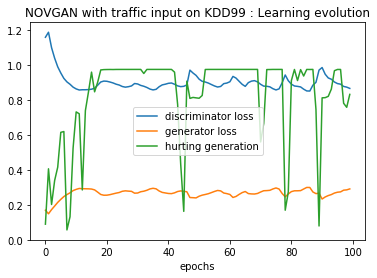

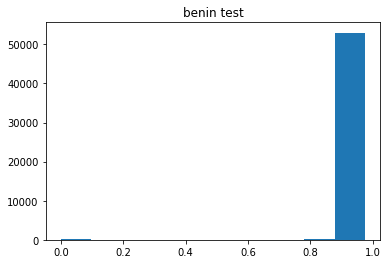

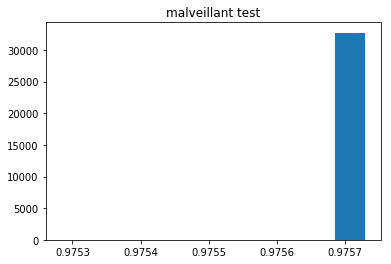

array([0.97572952, 0.97572952, 0.97572952, ..., 0.97572952, 0.97572952,
       0.97572952])

In [4]:
############
# Training #
############
start = time()
learned = novgan_trafic_input.train(x_train=x_train, epochs=epochs,
                                    x_train_bad=x_train_bad,
                                    print_recap=True)
end = time()
duration = end - start
save_time(duration=duration, location="tmp/", title=title)

novgan_trafic_input.hurting(x=x_test, title="benin test", print_mode=True)
novgan_trafic_input.hurting(x=x_test_bad, title="malveillant test", print_mode=True)

In [5]:
generated = novgan_trafic_input.generate(number=10000, x_bad=x_test[:1000])

In [6]:
from __future__ import print_function, division
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
from keras.initializers import glorot_uniform



leaky_relu = .1
auto_encoder  = Sequential()
auto_encoder.add(Dense(64,
                    input_dim=data_dim,
                    kernel_initializer=glorot_uniform()))
auto_encoder.add(LeakyReLU(leaky_relu))
auto_encoder.add(Dense(32))
auto_encoder.add(LeakyReLU(leaky_relu))
auto_encoder.add(BatchNormalization())
auto_encoder.add(Dense(data_dim))
auto_encoder.add(LeakyReLU(leaky_relu))
auto_encoder.add(Dense(data_dim))
auto_encoder.add(BatchNormalization())
auto_encoder.compile(loss="mse",optimizer=Adam(0.0002, 0.5))
auto_encoder.fit(x_train, x_train, epochs=10, batch_size=128)
x_ae_test = auto_encoder.predict(x_test_bad)

Epoch 1/10
42707/42707 [==============================] - 2s 38us/step - loss: 1.4687
Epoch 2/10
42707/42707 [==============================] - 1s 19us/step - loss: 0.9169
Epoch 3/10
42707/42707 [==============================] - 1s 19us/step - loss: 0.7149
Epoch 4/10
42707/42707 [==============================] - 1s 18us/step - loss: 0.5926
Epoch 5/10
42707/42707 [==============================] - 1s 20us/step - loss: 0.4969
Epoch 6/10
42707/42707 [==============================] - 1s 21us/step - loss: 0.4171
Epoch 7/10
42707/42707 [==============================] - 1s 23us/step - loss: 0.3474
Epoch 8/10
42707/42707 [==============================] - 1s 20us/step - loss: 0.2874
Epoch 9/10
42707/42707 [==============================] - 1s 21us/step - loss: 0.2352
Epoch 10/10
42707/42707 [==============================] - 1s 19us/step - loss: 0.1901


In [7]:
x_train.shape

(42707, 115)

In [16]:
x10 = auto_encoder.predict(x_test[:100].reshape(((100,115))))
x1 = auto_encoder.predict(x_test[0].reshape(((1,115))))

In [18]:
np.max(x1[0] - x10[0])

7.748604e-07

In [9]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)  

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
x_pca = pca.transform(x_train)
x_pca_gen = pca.transform(generated)
x_pca_ae = pca.transform(x_train_bad)

In [11]:
from matplotlib import pyplot as plt

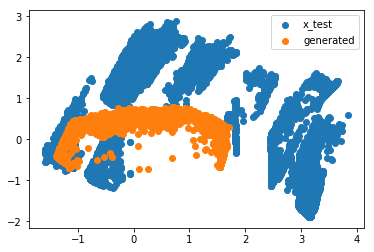

In [12]:
plt.scatter(x_pca[:,0].tolist(),x_pca[:,1].tolist(), label="x_test")
plt.scatter(x_pca_gen[:,0].tolist(),x_pca_gen[:,1].tolist(), label="generated")
# plt.scatter(x_pca_ae[:,0].tolist(),x_pca_ae[:,1].tolist(), label="auto_encoded")
plt.legend()
plt.show()
plt.close()

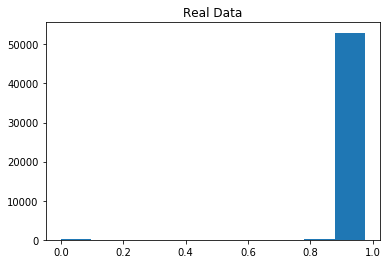

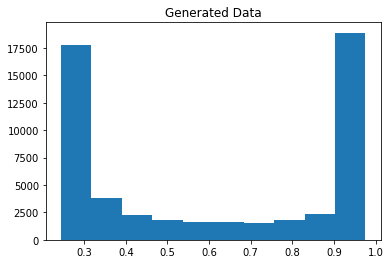

array([0.29741696, 0.2567965 , 0.35987151, ..., 0.97572952, 0.24951506,
       0.51835766])

In [13]:
############
# Plotting #
############
novgan_trafic_input.hurting(x=x_test, print_mode=True,title="Real Data")
novgan_trafic_input.hurting(x=novgan_trafic_input.generate(number=len(x_test), x_bad=x_test_bad[:len(x_test)]),
               print_mode=True,
               title="Generated Data")

In [14]:
noise = np.random.random(114).reshape((1,114))